##  Plots in the Paper 

In this notebook, you can generate the plots in the paper displayed in the paper "A Dual Study on Analyzing Image Recompression Effects and Realism Assessment via Kolmogorov Complexity"

### Heatmap from Section 2.3.2 Cross-Compression Between Traditional and Learned Codecs

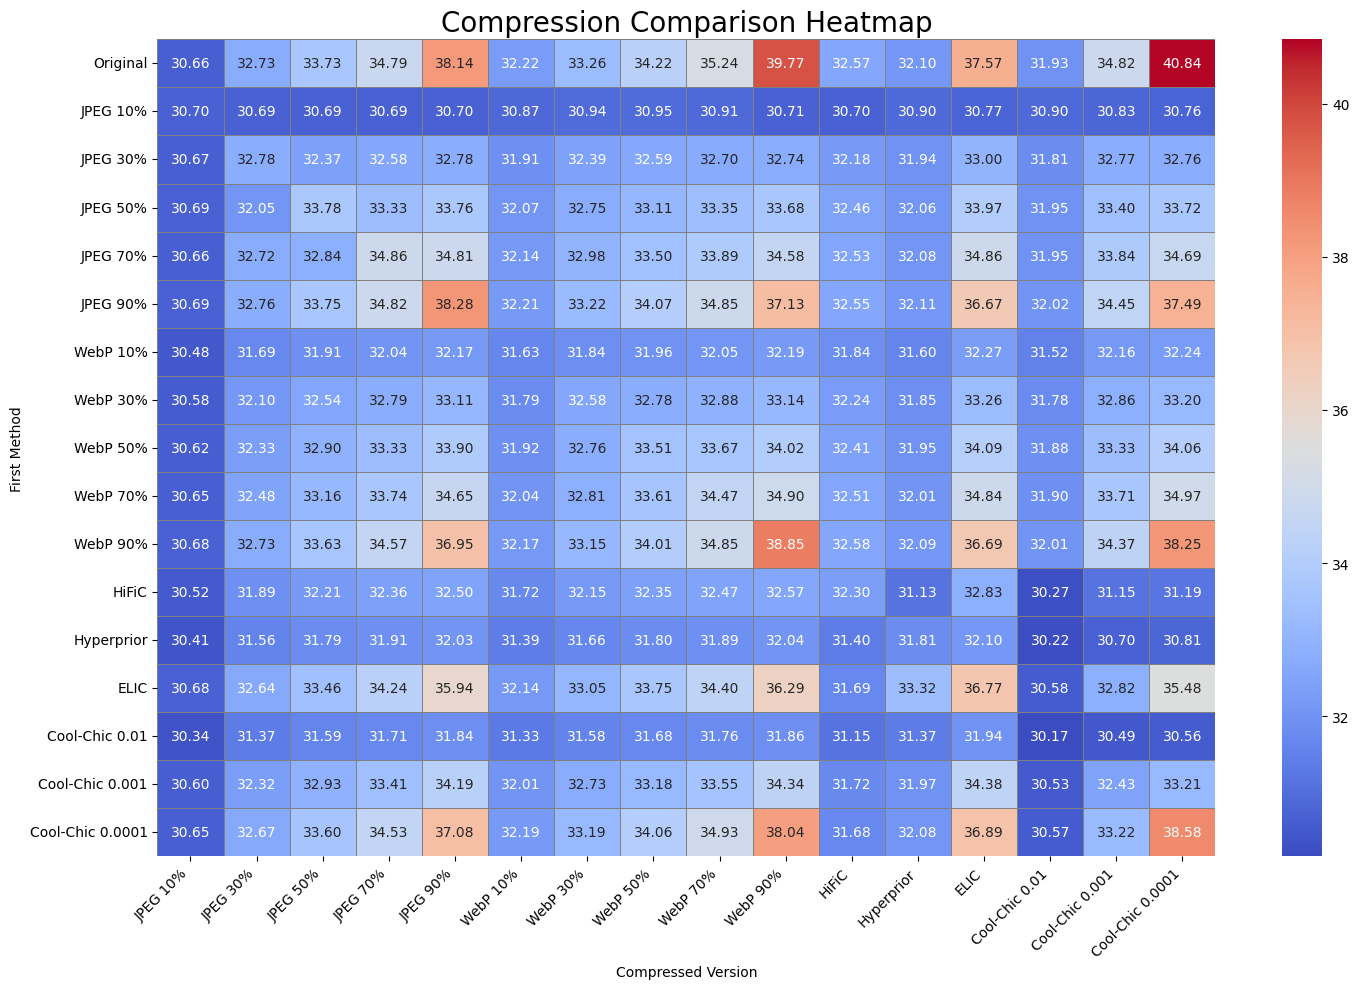

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "heatmap_data.csv"  #path to csv, change if you have a different one
df = pd.read_csv(csv_path)

df.set_index("Method", inplace=True)

# Original as Second Method is avoided for reducing redundancy
if "Original" in df.columns:
    df = df.drop(columns=["Original"])


plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor='gray')
plt.title("Compression Comparison Heatmap", fontsize=20)
plt.xlabel("Compressed Version")
plt.ylabel("First Method")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Graphs from the Section 2.3.3 Learned Image Compression under Recompression

In [78]:
def plot_rate_distortion(csv_path, metric="Average PSNR"):
    """
    Plots rate-distortion curves from a CSV file.
    
    Parameters:
    - csv_path: str, path to CSV file
    - metric: str, column name for the metric to plot on the Y-axis (e.g., "Average PSNR", "LPIPS", "FID")
    
    CSV must have columns: Algorithm, Cycle, Average Bitrate (bpp), and the metric column.
    
    Each Algorithm is a line.
    Each Cycle is a point on lines with consistent marker across Algorithms.
    """
    df = pd.read_csv(csv_path)
    
    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in CSV columns: {df.columns.tolist()}")
    
    plt.figure(figsize=(10, 6))
    
    # Define markers for cycles dynamically based on unique cycles
    unique_cycles = sorted(df['Cycle'].unique())
    markers_list = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # extend if needed
    cycle_markers = {cycle: markers_list[i % len(markers_list)] for i, cycle in enumerate(unique_cycles)}
    
    # Prepare colors for algorithms
    algorithms = df['Algorithm'].unique()
    palette = sns.color_palette(n_colors=len(algorithms))
    color_dict = dict(zip(algorithms, palette))
    
    for alg in algorithms:
        group_data = df[df['Algorithm'] == alg]
        color = color_dict[alg]
        
        # Plot line
        plt.plot(
            group_data["Average Bitrate (bpp)"],
            group_data[metric],
            label=alg,
            color=color
        )
        
        # Plot points with cycle-specific markers
        for cycle in unique_cycles:
            cycle_data = group_data[group_data['Cycle'] == cycle]
            if not cycle_data.empty:
                plt.scatter(
                    cycle_data["Average Bitrate (bpp)"],
                    cycle_data[metric],
                    marker=cycle_markers[cycle],
                    s=50,
                    edgecolor='black',
                    color=color,
                    label=f'Cycle {cycle}' if alg == algorithms[0] else "",
                    zorder=5
                )
    
    plt.title(f"Rate-Distortion Curve ({metric} vs. Bitrate)")
    plt.xlabel("Average Bitrate (bpp)")
    plt.ylabel(metric)
    plt.grid(True)
    
    # Build legend
    handles, labels = plt.gca().get_legend_handles_labels()
    
    alg_handles = []
    alg_labels = []
    cycle_handles = []
    cycle_labels = []
    
    for h, l in zip(handles, labels):
        if l.startswith('Cycle'):
            if l not in cycle_labels:
                cycle_handles.append(h)
                cycle_labels.append(l)
        else:
            alg_handles.append(h)
            alg_labels.append(l)
    
    plt.legend(
        handles=alg_handles + cycle_handles,
        labels=alg_labels + cycle_labels,
        title="Algorithm and Cycle",
        loc="best"
    )
    
    plt.tight_layout()
    plt.show()

First as metric, we have PSNR 

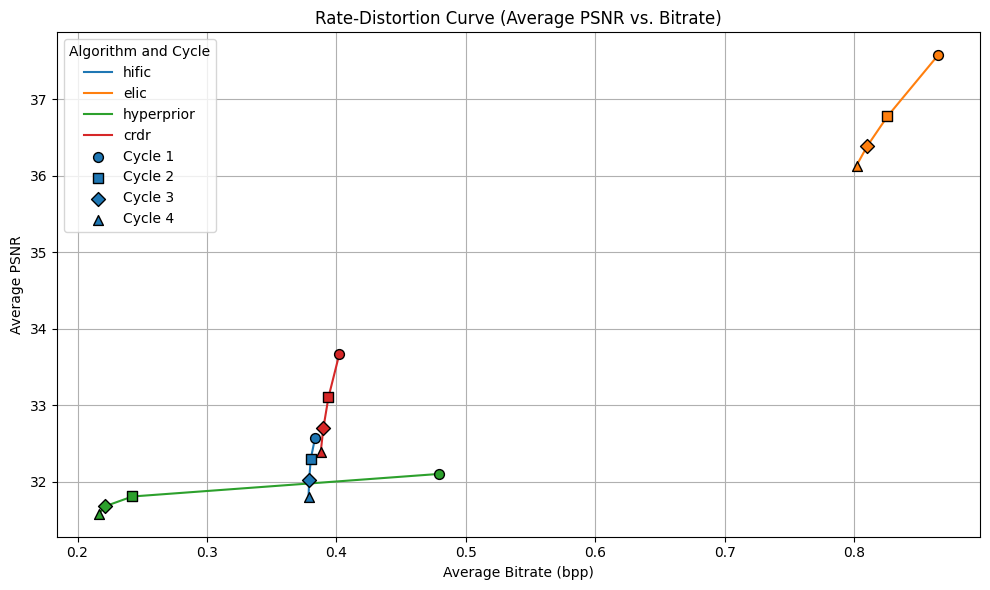

In [79]:
csv_path = "psnr_bitrate_summary.csv"
plot_rate_distortion(csv_path, metric="Average PSNR")

LPIPS as metric

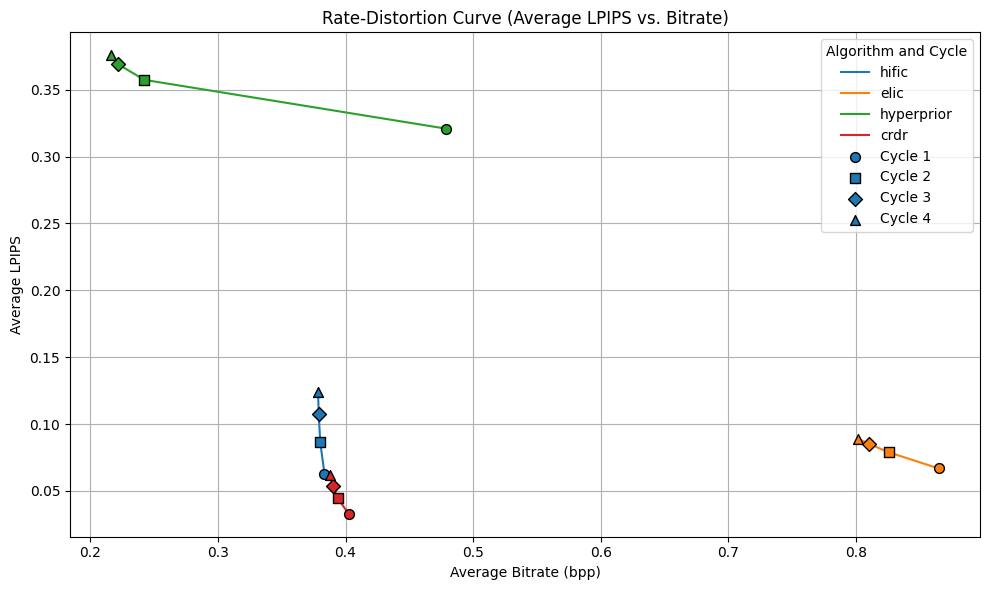

In [80]:
csv_path = "lpips_bitrate_summary.csv"
plot_rate_distortion(csv_path, metric="Average LPIPS")

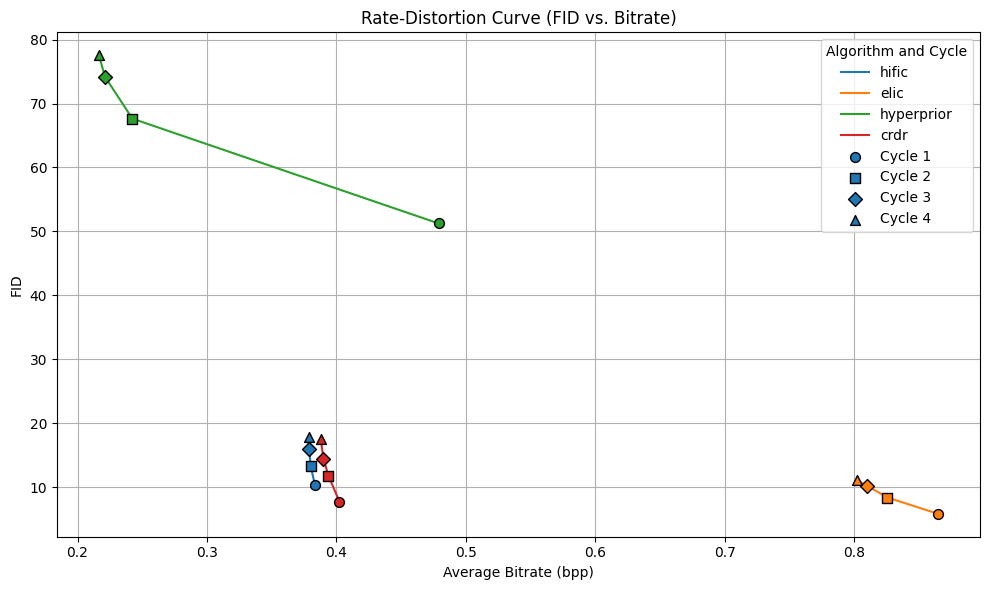

In [81]:
csv_path = "fid_bitrate_summary.csv"
plot_rate_distortion(csv_path, metric="FID")

### Plots of CRDR with multiple recompression cycles

Section 2.3.4 Exploring the Impact of Bitrate and Realism in CRDR

In [82]:
models = {
    "Beta 0.0": "CRDR_Modelwithbeta0.0_rs_data.csv",
    "Beta 2.5": "CRDR_Modelwithbeta2.5_rs_data.csv",
    "Beta 5.12": "CRDR_Modelwithbeta5.12_rs_data.csv"
}

In [93]:
from matplotlib.lines import Line2D
import numpy as np


def crdr_cycles_plot(csv_path, metric='FID', anchor='JPEG'):
    df = pd.read_csv(csv_path)
    marker_size = 50 

 
    df['Cycle'] = df['Cycle'].fillna(anchor)

    # Extract JPEG and CRDR qualities (assumes ordering corresponds)
    anchor_qualities = sorted(df[df['Algorithm']==anchor]['Quality'].unique())
    crdr_qualities = sorted(df[df['Algorithm']=='CRDR']['Quality'].unique())

    markers = ['^', 's', 'o', 'D', 'P', 'X', '*', 'v']
    marker_map = {q: markers[i % len(markers)] for i, q in enumerate(crdr_qualities)}

    cycles = sorted(df['Cycle'].unique())
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:purple', 'tab:brown', 'tab:gray']
    color_map = {cycle: colors[i % len(colors)] for i, cycle in enumerate(cycles)}

    plt.figure(figsize=(10,6))

    # We'll extract bd-rates per cycle from CSV (use first non-empty value)
    bd_rates = {}
    for cycle in cycles:
        cycle_bd_rates = df[df['Cycle'] == cycle]['BD-rate'].dropna().unique()
        if len(cycle_bd_rates) > 0:
            bd_rates[cycle] = cycle_bd_rates[0]  # Take the first BD-rate value found as string

    # Plot lines & points
    for cycle in cycles:
        cycle_df = df[df['Cycle'] == cycle].sort_values(by='Quality')
        color = color_map[cycle]

        plt.plot(cycle_df['BPP'], cycle_df[metric], color=color, linestyle='-', label=cycle)

        for _, row in cycle_df.iterrows():
            q = row['Quality']
            m = marker_map.get(q, 'o')
            plt.scatter(row['BPP'], row[metric], marker=m, color=color,
                        edgecolor='black', s=marker_size)

    # Marker legend for paired qualities
    marker_handles = []
    marker_labels = []
    for i, (anchor_q, crdr_q) in enumerate(zip(anchor_qualities, crdr_qualities)):
        m = markers[i % len(markers)]
        marker_handles.append(Line2D([0], [0], marker=m, color='black', linestyle='',
                                     markersize=np.sqrt(marker_size), markerfacecolor='gray', markeredgecolor='black'))
        marker_labels.append(f'{anchor} Q = {anchor_q} / CRDR q = {crdr_q}')

    # Color legend with BD-rate if available
    color_handles, color_labels = plt.gca().get_legend_handles_labels()
    new_labels = []
    for label in color_labels:
        if label != anchor and label in bd_rates:
            new_labels.append(f"{label} CRDR (BD-rate={bd_rates[label]})")
        else:
            new_labels.append(label)

    plt.xlabel('Bitrate (bpp)')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Bitrate')
    plt.grid(True)

    plt.legend(handles=color_handles + marker_handles,
               labels=new_labels + marker_labels,
               loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=2, fontsize=10,
               title='Lines = Cycle / Markers = Quality pairs')

    plt.tight_layout()
    plt.show()

    

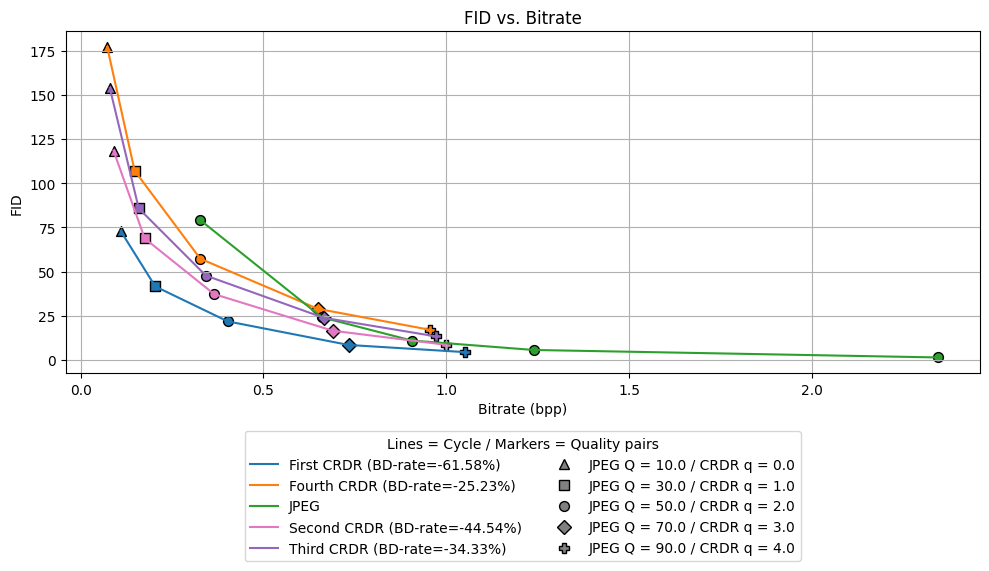

In [94]:
crdr_cycles_plot(models["Beta 0.0"], anchor='JPEG')

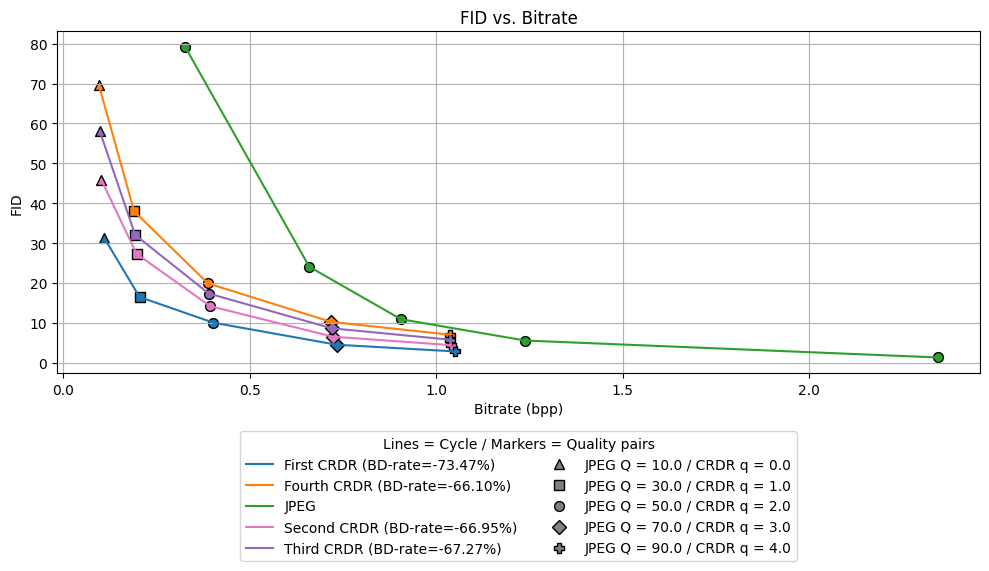

In [95]:
crdr_cycles_plot(models["Beta 2.5"], anchor='JPEG')

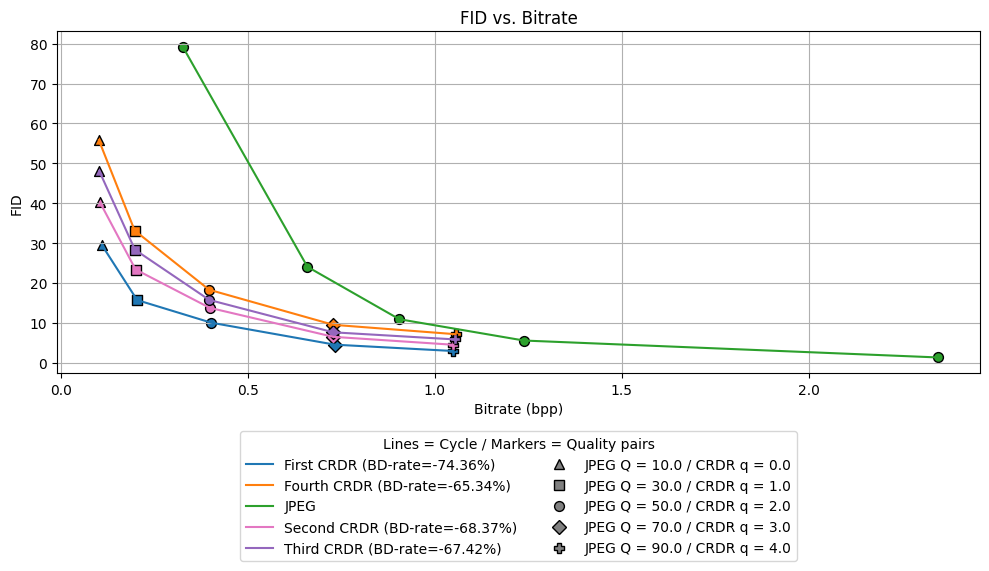

In [96]:
crdr_cycles_plot(models["Beta 5.12"], anchor='JPEG')

JPEG as a reference point to calculate BD-rate values based on FID scores for each CRDR model across four compression cycles

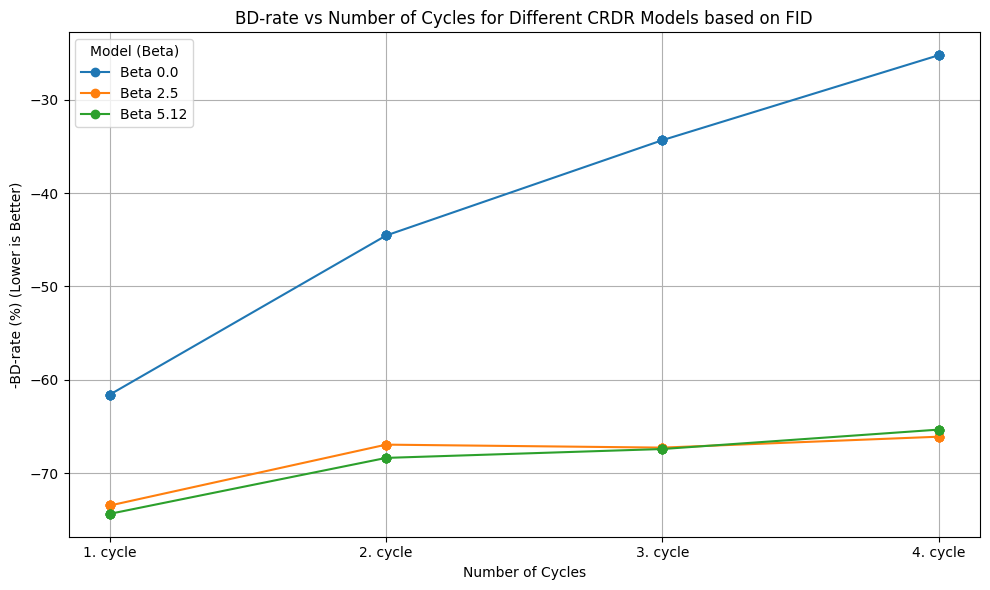

In [97]:
cycle_map = {"First": 1, "Second": 2, "Third": 3, "Fourth": 4}
plt.figure(figsize=(10, 6))


for label, filepath in models.items():
    df = pd.read_csv(filepath)
    crdr_df = df[df["Algorithm"] == "CRDR"].copy()
    

    crdr_df["Cycle_Num"] = crdr_df["Cycle"].map(cycle_map)
    

    crdr_df["BD-rate"] = crdr_df["BD-rate"].str.replace("%", "").astype(float)
    
    
    crdr_df = crdr_df.sort_values("Cycle_Num")
    
    
    plt.plot(
        crdr_df["Cycle_Num"],
        crdr_df["BD-rate"],
        marker='o',
        label=label
    )

plt.xlabel("Number of Cycles")
plt.ylabel("-BD-rate (%) (Lower is Better)")
plt.title("BD-rate vs Number of Cycles for Different CRDR Models based on FID")
plt.xticks([1, 2, 3, 4], labels=["1. cycle", "2. cycle", "3. cycle", "4. cycle"])
plt.grid(True)
plt.legend(title="Model (Beta)")
plt.tight_layout()



plt.show()

In [98]:
models_psnr = {
    "Beta 0.0": "CRDR_Modelwithbeta0.0_data.csv",
    "Beta 2.5": "CRDR_Modelwithbeta2.5_data.csv",
    "Beta 5.12": "CRDR_Modelwithbeta5.12_data.csv"
}

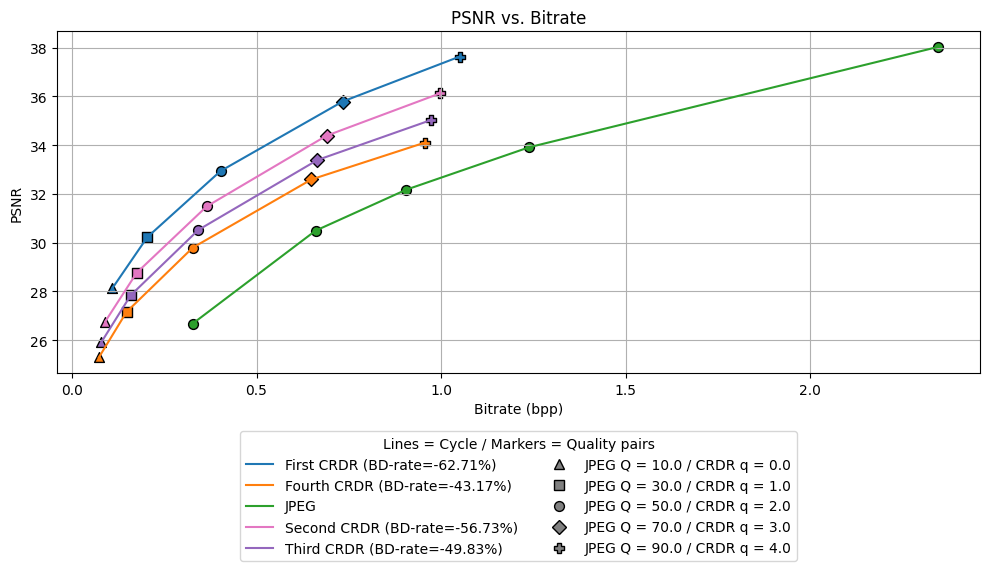

In [99]:
crdr_cycles_plot(models_psnr["Beta 0.0"], metric='PSNR', anchor='JPEG')

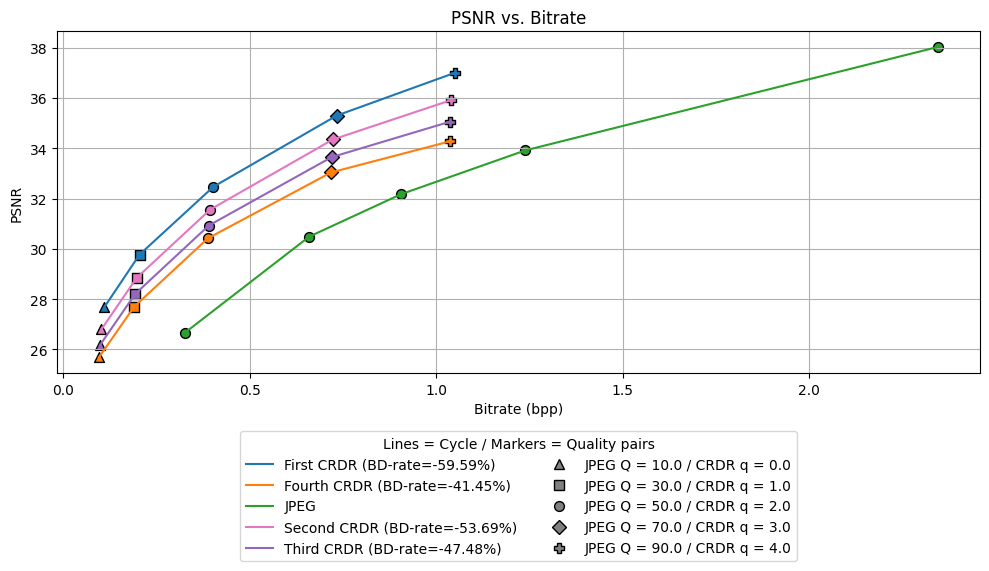

In [100]:
crdr_cycles_plot(models_psnr["Beta 2.5"], metric='PSNR', anchor='JPEG')

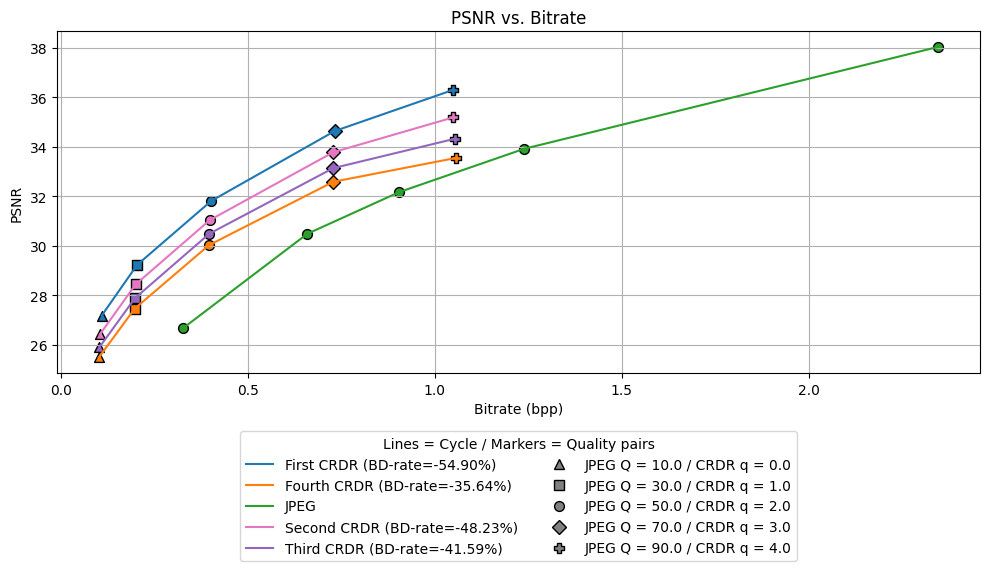

In [101]:
crdr_cycles_plot(models_psnr["Beta 5.12"], metric='PSNR', anchor='JPEG')

BD-rate of PSNR with JPEG as anchor 

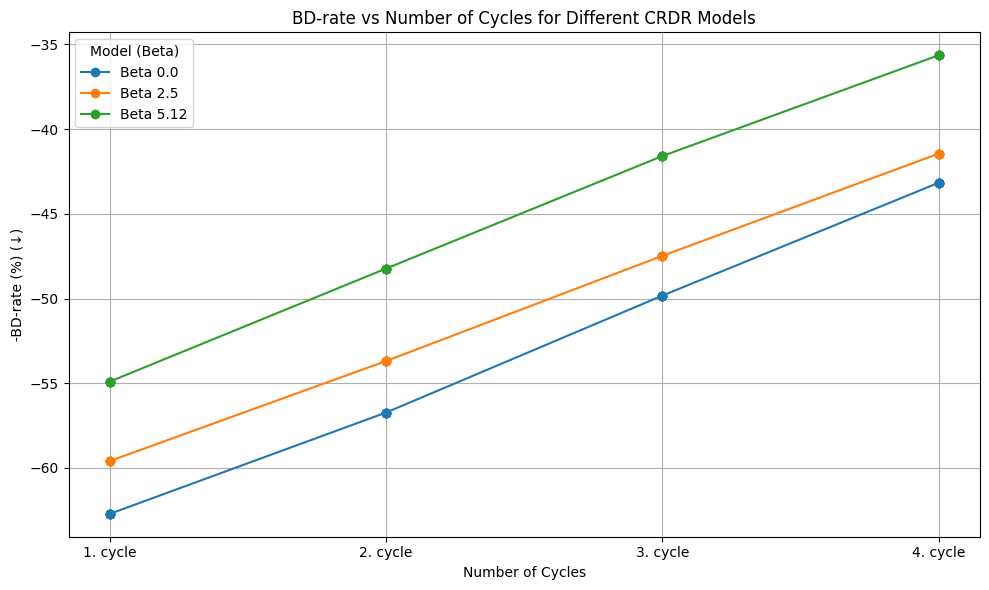

In [102]:
cycle_map = {"First": 1, "Second": 2, "Third": 3, "Fourth": 4}
plt.figure(figsize=(10, 6))

for label, filepath in models_psnr.items():
    df = pd.read_csv(filepath)
    crdr_df = df[df["Algorithm"] == "CRDR"].copy()
    
    crdr_df["Cycle_Num"] = crdr_df["Cycle"].map(cycle_map)
    
    crdr_df["BD-rate"] = crdr_df["BD-rate"].str.replace("%", "").astype(float)
    
    
    crdr_df = crdr_df.sort_values("Cycle_Num")
    
    plt.plot(
        crdr_df["Cycle_Num"],
        crdr_df["BD-rate"],
        marker='o',
        label=label
    )

plt.xlabel("Number of Cycles")
plt.ylabel("-BD-rate (%) (↓)")
plt.title("BD-rate vs Number of Cycles for Different CRDR Models")
plt.xticks([1, 2, 3, 4], labels=["1. cycle", "2. cycle", "3. cycle", "4. cycle"])
plt.grid(True)
plt.legend(title="Model (Beta)")
plt.tight_layout()


plt.show()


In [103]:
models_vvc = {
    "Beta 0.0": "CRDR_Modelwithbeta0.0_rs_vvc.csv",
    "Beta 2.5": "CRDR_Modelwithbeta2.5_rs_vvc.csv",
    "Beta 5.12": "CRDR_Modelwithbeta5.12_rs_vvc.csv"
}

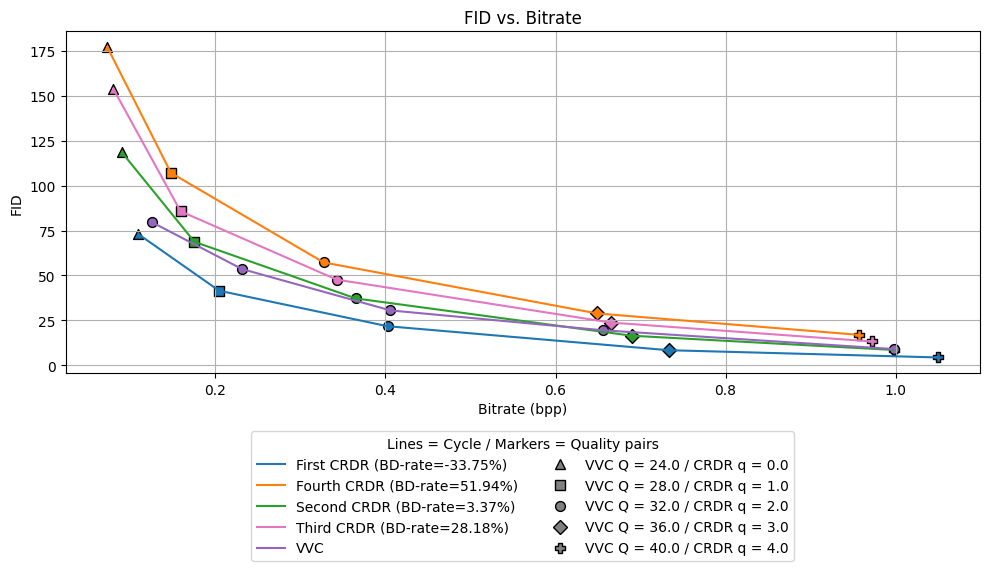

In [105]:
crdr_cycles_plot(models_vvc["Beta 0.0"], metric='FID', anchor='VVC')

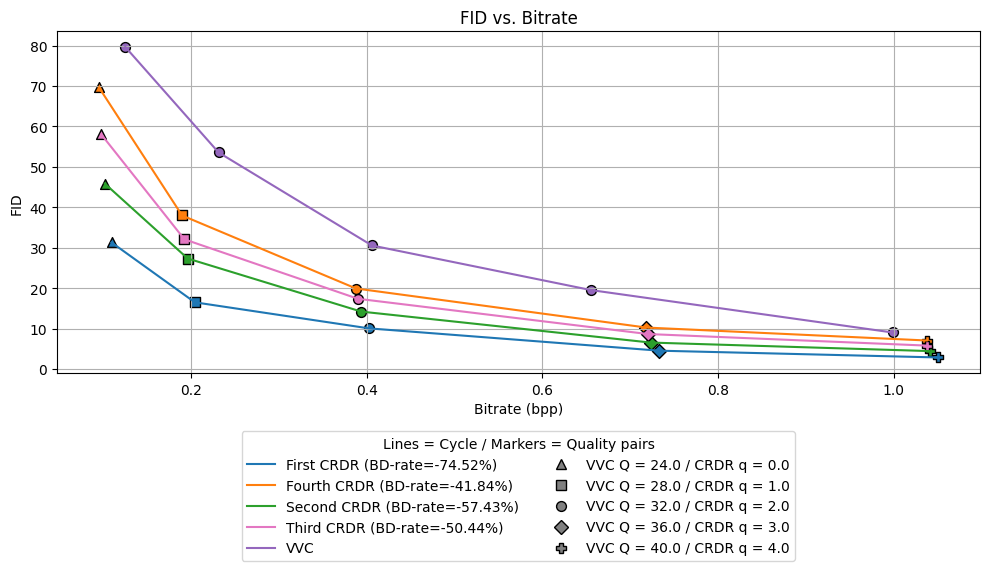

In [106]:
crdr_cycles_plot(models_vvc["Beta 2.5"], metric='FID', anchor='VVC')

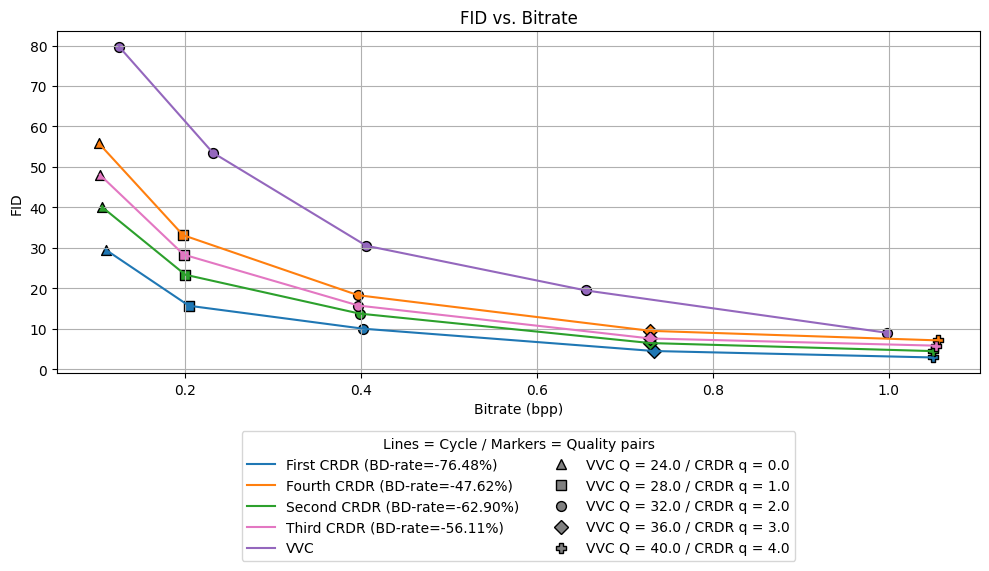

In [107]:
crdr_cycles_plot(models_vvc["Beta 5.12"], metric='FID', anchor='VVC')

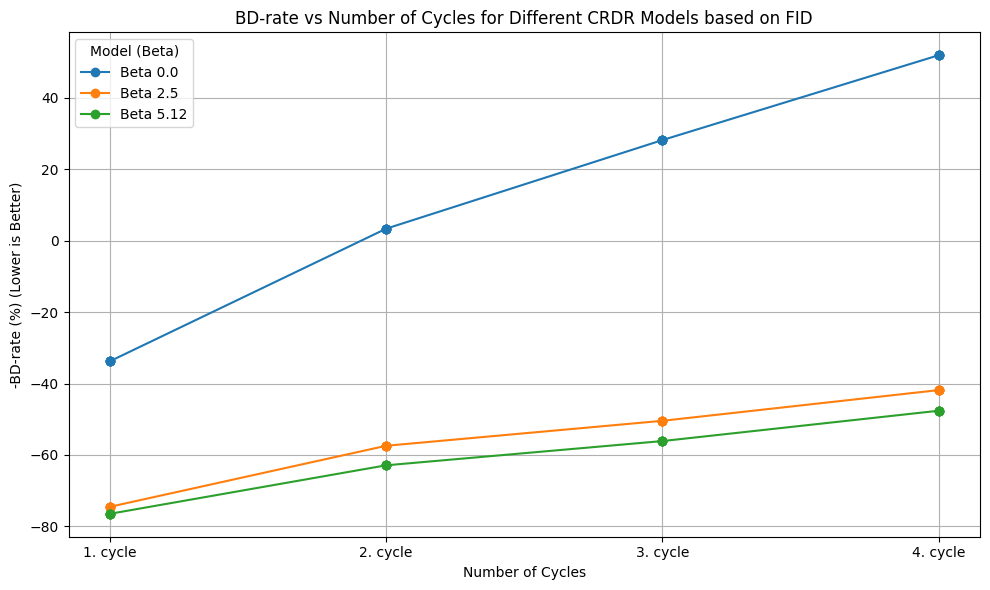

In [108]:
cycle_map = {"First": 1, "Second": 2, "Third": 3, "Fourth": 4}
plt.figure(figsize=(10, 6))


for label, filepath in models_vvc.items():
    df = pd.read_csv(filepath)
    crdr_df = df[df["Algorithm"] == "CRDR"].copy()
    

    crdr_df["Cycle_Num"] = crdr_df["Cycle"].map(cycle_map)
    

    crdr_df["BD-rate"] = crdr_df["BD-rate"].str.replace("%", "").astype(float)
    
    
    crdr_df = crdr_df.sort_values("Cycle_Num")
    
    
    plt.plot(
        crdr_df["Cycle_Num"],
        crdr_df["BD-rate"],
        marker='o',
        label=label
    )

plt.xlabel("Number of Cycles")
plt.ylabel("-BD-rate (%) (Lower is Better)")
plt.title("BD-rate vs Number of Cycles for Different CRDR Models based on FID")
plt.xticks([1, 2, 3, 4], labels=["1. cycle", "2. cycle", "3. cycle", "4. cycle"])
plt.grid(True)
plt.legend(title="Model (Beta)")
plt.tight_layout()



plt.show()

In [112]:
def crdr_config_plots(csv_path, metric='FID', marker_size=60):
    df = pd.read_csv(csv_path)

    plt.figure(figsize=(10, 8))

    # Extract and sort unique configurations and quality levels
    configurations = df['Configuration'].unique()
    qualities = sorted(df['Quality'].unique())

    # Define markers
    markers = ['^', 's', 'o', 'D', 'P', 'X', '*']
    marker_map = {q: markers[i % len(markers)] for i, q in enumerate(qualities)}

    # Define colors using matplotlib default cycle
    from itertools import cycle
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    # Line and marker handles for legends
    line_handles = []
    line_labels = []
    marker_handles = []
    marker_labels = []

    # Plot lines and markers
    for config in configurations:
        color = next(color_cycle)
        config_data = df[df['Configuration'] == config]
        config_data = config_data.sort_values(by='Quality')

        bpps = config_data['BPP'].tolist()
        values = config_data[metric].tolist()
        qs = config_data['Quality'].tolist()

        # Plot line
        line = plt.plot(bpps, values, linestyle='-', label=config, color=color)
        line_handles.append(line[0])
        line_labels.append(config)

        # Plot points with matching markers
        for bpp, val, q in zip(bpps, values, qs):
            plt.scatter(bpp, val, marker=marker_map[q], color=color, s=marker_size)

    # Add marker legend
    for q in qualities:
        marker_handles.append(plt.scatter([], [], marker=marker_map[q], color='black', s=marker_size))
        marker_labels.append(f"Quality = {q}")

    # Final legend with lines and markers
    plt.legend(handles=line_handles + marker_handles,
               labels=line_labels + marker_labels,
               loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=2, fontsize=10,
               title='Lines = Configuration / Markers = Quality')

    plt.xlabel("Bitrate (bpp)")
    plt.ylabel(metric)
    plt.title(f"Rate-{metric} Curve per Configuration")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

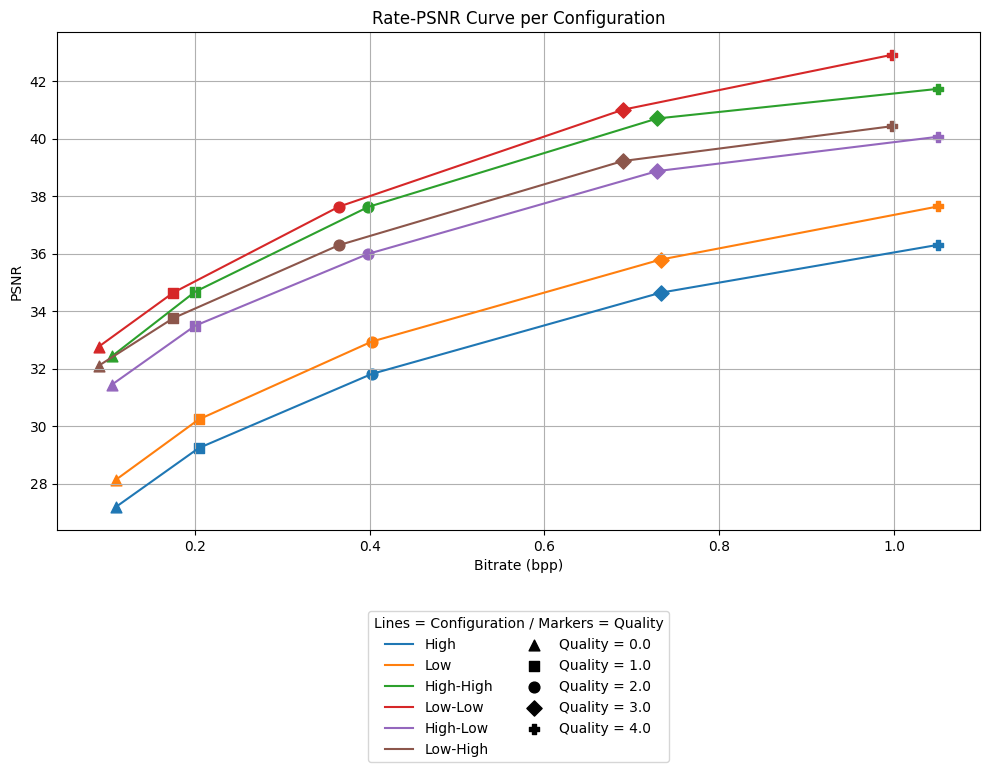

In [113]:
crdr_config_plots("CRDR_experiment_hi_low.csv", metric='PSNR')

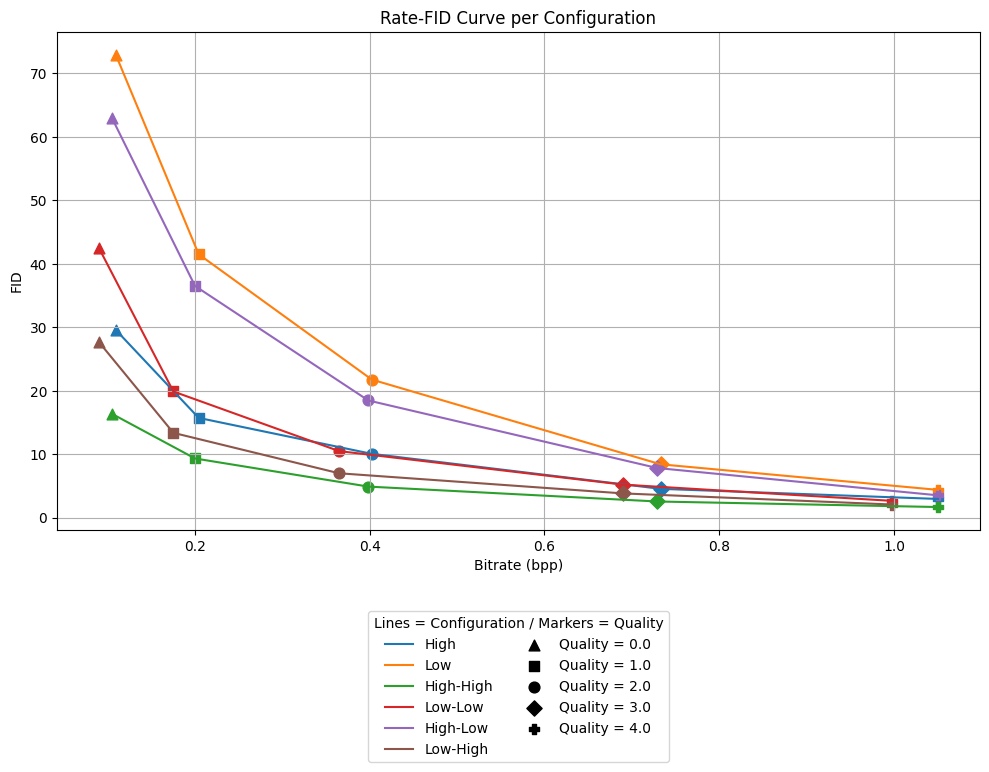

In [114]:
crdr_config_plots("CRDR_experiment_hi_low_fid.csv", metric='FID')